In [40]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


#import clean data
df = pd.read_csv("C:/Users/jhall/Desktop/D209/churn_clean.csv")

#inspect data
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CaseOrder             10000 non-null  int64  
 1   Customer_id           10000 non-null  object 
 2   Interaction           10000 non-null  object 
 3   UID                   10000 non-null  object 
 4   City                  10000 non-null  object 
 5   State                 10000 non-null  object 
 6   County                10000 non-null  object 
 7   Zip                   10000 non-null  int64  
 8   Lat                   10000 non-null  float64
 9   Lng                   10000 non-null  float64
 10  Population            10000 non-null  int64  
 11  Area                  10000 non-null  object 
 12  TimeZone              10000 non-null  object 
 13  Job                   10000 non-null  object 
 14  Children              10000 non-null  int64  
 15  Age                 

In [41]:
# Convert 'Yes' to 1 and 'No' to 0
columns_to_convert = [
    'Churn'
]

for column in columns_to_convert:
    df[column] = df[column].apply(lambda x: 1 if x == 'Yes' else 0)

In [42]:
# Selecting a subset of columns that are relevant for churn 
selected_columns = [
    'Age', 'Income', 'Children', 'Outage_sec_perweek', 'Email', 'Contacts', 
    'Yearly_equip_failure', 'Techie', 'Contract', 'Port_modem', 'Tablet', 
    'InternetService', 'Phone', 'Multiple', 'OnlineSecurity', 'OnlineBackup', 
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
    'PaperlessBilling', 'PaymentMethod', 'MonthlyCharge', 'Bandwidth_GB_Year','Churn'
]

# Filtering the dataset to keep only the selected columns
df_filtered = df[selected_columns]


In [43]:
# Encoding categorical columns using pd.get_dummies
categorical_columns = df_filtered.select_dtypes(include=['object']).columns
df_filtered_encoded = pd.get_dummies(df_filtered, columns=categorical_columns)


In [44]:
# Separating the features and the target variable
X = df_filtered_encoded.drop('Churn', axis=1)
y = df_filtered_encoded['Churn']

# Applying standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [45]:
# Splitting the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)




In [92]:
#Exporting dfs
df_filtered_encoded.to_csv('C:/Users/jhall/Desktop/D209/D209 Part 1 KNN.csv', index=False)

# Convert the scaled features back into a DataFrame
X_train_df = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X_train.shape[1])])
X_test_df = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(X_test.shape[1])])

# Add the labels to the features DataFrame
train_df = pd.concat([X_train_df, y_train.reset_index(drop=True)], axis=1)
test_df = pd.concat([X_test_df, y_test.reset_index(drop=True)], axis=1)

# Export to CSV
train_df.to_csv('C:/Users/jhall/Desktop/D209/D209 Part 1 Train.csv', index=False)
test_df.to_csv('C:/Users/jhall/Desktop/D209/D209 Part 1 Test.csv', index=False)


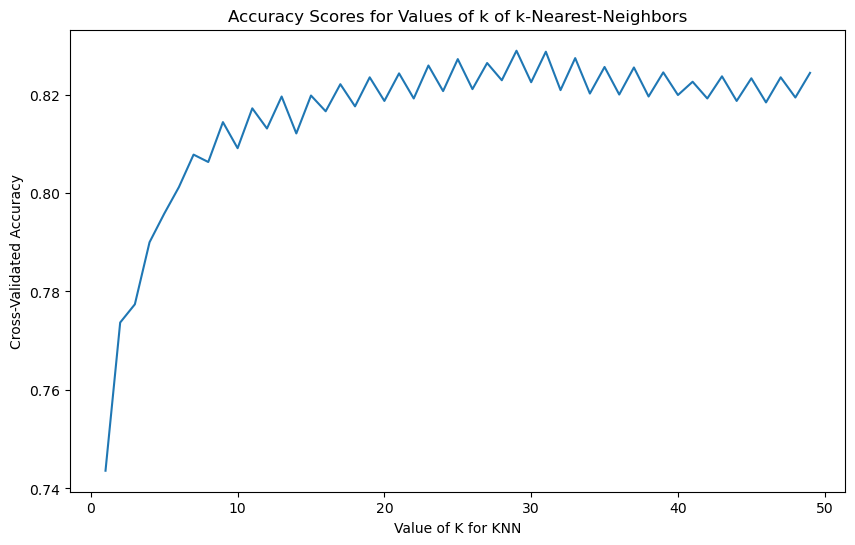

In [49]:
# Range of k to test
k_range = range(1, 50)

# Empty list to store scores
k_scores = []

# Loop through reasonable values of k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Obtain cross_val_score for KNeighborsClassifier with k neighbors
    scores = cross_val_score(knn, X_scaled, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())

# Plot the relationship between k and the average accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Accuracy Scores for Values of k of k-Nearest-Neighbors')
plt.show()


In [86]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [87]:
print(accuracy)

0.8156666666666667


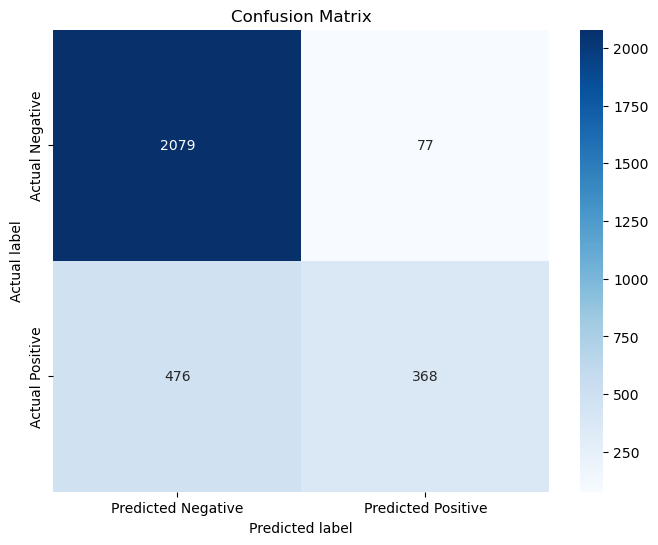

In [93]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted Negative',
            'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

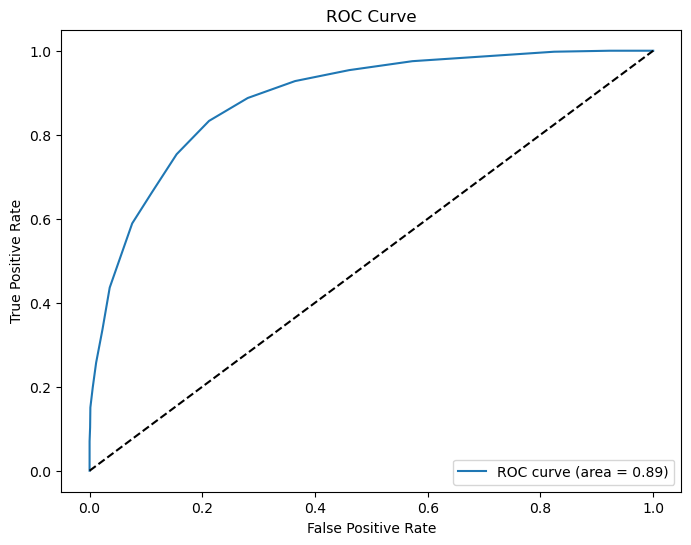

In [91]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Get probabilities for the positive class
y_probs = knn.predict_proba(X_test)[:, 1]  
roc_auc = roc_auc_score(y_test, y_probs)

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()